# 使用 `braincell` 对 Hodgkin-Huxley 神经元仿真

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_neuron-zh.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_neuron-zh.ipynb)

本节介绍使用 `braincell` 对 Hodgkin-Huxley 神经元仿真。

## HH 模型概述

艾伦 · 霍奇金（Allen Hodgkin， 1914 - 1998）和安德鲁 · 赫胥黎（Andrew Huxley， 1917 - 2012）首次描述了动作电位的产生机制。 在 1950 年左右两人通过一系列的实验阐明了动作电位的离子机制，并于 1963 年凭借动作电位机制的阐述获得了诺贝尔生理学或医学奖。 霍奇金 - 赫胥黎模型（Hodgkin - Huxley model， HH 模型）是第一个精准描述神经元动作电位产生过程的数学模型。

对于一个 HH 型神经元，我们主要关注它的细胞膜。神经元细胞膜是分隔细胞内外的磷脂双分子层结构，在细胞质或胞外的水性环境下，水溶性的带电分子，如离子和神经递质等，都不能被动地穿过细胞膜的磷脂双分子层，因此需要运输蛋白将它们从一侧运至另一侧。离子通道就是一种跨膜运输蛋白。

有些离子通道是由闸门控制的，可以在电、化学或物理刺激下开放或关闭。简单来说，对应的离子通道允许对应的离子通过，如钠离子通道允许钠离子通过，钾离子通道允许钾离子通过。

有些离子通道是无闸门的，这些通道始终开放，没有闸门控制。HH 模型将这些通道合并成一个等效的漏电流通道。

HH 型神经元细胞膜的典型结构如下图：

![层级结构](_static/image/braincell_HH_neuron_structure.png)

对 HH 型神经元的机制进行总结：
- 神经元细胞由细胞膜包围，膜上分布着各种离子通道
- 离子通道控制离子的进出
- 离子的流动会引起细胞膜内外电位的变化，从而驱动神经元的活动

为了描述细胞膜电位的变化以及动作电位的产生，一种有效的描述方法是构建出神经元的等效电路。
通常这种等效电路模型包含三个部分：
- 代表离子通道的电阻
- 代表离子浓度梯度的电源
- 代表细胞膜储存电荷能力的电容

神经元各部分与等效电路组件的对应关系如下图：

![等效电路组件](_static/image/braincell_HH_neuron_part.png)

细胞膜电容由 $ C_m $ 表示，离子通道可等效为一个包含电阻 $ R_X $ 和电源 $ E_X $ 的电路元件。
由于电阻是电导的倒数，因此离子通道的电导为 $ g_X = 1 / R_X $ 。此处的 $ X $ 指代不同的离子，如 $ Na $ 、 $ K $ 等。

结合以上，HH 模型的等效电路如下图：

![等效电路](_static/image/braincell_HH_neuron_circuit.png)

电容器存储的电荷量 $ q $ 与膜电位 $ V_m $ 的关系可表示为 $ q = C_m V_m $ 。

掌握了以上知识后，我们可以开始对 HH 型神经元建模。

## 离子通道建模

如上述， HH 型神经元的电学特性主要由离子通道控制，所以如果想对神经元甚至网络进行准确的建模，首先要学会如何建模离子通道。

在 HH 模型中，每个离子通道都被视为一种跨膜蛋白质，形成一个孔，离子可以通过该孔沿着其浓度梯度扩散。这些孔有许多闸门，可以打开也可以关闭，而每个闸门打开或者关闭的概率取决于膜电位。

对于每个闸门，将 $ \alpha(V) $ 和 $ \beta(V) $ 分别定义为闸门从关闭状态到打开状态以及从打开状态到关闭状态的电压依赖的速率。令 $ m $ 是闸门打开的比例， $ 1 - m $ 是闸门关闭的比例，则我们可以得到:

$$
\frac{dm}{dt} = \alpha(V)(1 - m) - \beta(V)m
$$

$$
= \frac{m_{\infty}(V) - m}{\tau(V)},
$$

其中

$$
m_{\infty}(V) = \frac{\alpha(V)}{\alpha(V) + \beta(V)}, \quad \tau(V) = \frac{1}{\alpha(V) + \beta(V)}.
$$

在 HH 模型中，$ m_{\infty}(V) $ 和 $ \tau(V) $ 中的参数 $ \alpha $、$ \beta $ 可以根据实验数据拟合计算得到。

闸门分为激活闸门和失活闸门。不同的离子通道拥有不同种类和数量的闸门，如典型的钠离子通道：

$$
g_{\text{Na}} = \bar{g}_{\text{Na}} m^3 h,
$$

其中 $ \bar{g}_{\text{Na}} $ 是钠离子通道的最大电导值，激活门控 $ m \in [0, 1] $ 和失活门控 $ h \in [0, 1] $ 是满足一阶动力学方程的变量，$ m^3 h $ 表示钠离子通道具有 3 个独立的激活闸门和 1 个独立的失活闸门，只有每个部位都打开，才能允许 $ \text{Na}^+ $ 通过。

相比之下，典型的钾离子通道只拥有激活闸门而没有失活闸门，漏电流通道则两种闸门都没有。

`braincell` 框架中对于离子通道的建模主要就依赖于上式。

以典型的钠离子通道为例，其数学形式如下：

$$
\begin{aligned}
g_{\mathrm{Na}} &= g_{\mathrm{max}} \cdot p^3 \cdot q \\
\frac{dp}{dt} &= \phi \left( \alpha_p (1-p) - \beta_p p \right) \\
\frac{dq}{dt} &= \phi \left( \alpha_q (1-h) - \beta_q h \right) \\
\end{aligned}
$$

其中 $\phi$ 是温度系数。

对其建模：

In [10]:
from typing import Union, Callable, Optional

import braincell
import braintools
import brainstate
import brainunit as u

from braincell.channel import SodiumChannel
from braincell import IonInfo, DiffEqState

In [11]:
class INa_p3q_markov(SodiumChannel):
    def __init__(
        self,
        size: brainstate.typing.Size,
        g_max: Union[brainstate.typing.ArrayLike, Callable] = 90. * (u.mS / u.cm ** 2),
        phi: Union[brainstate.typing.ArrayLike, Callable] = 1.,
        name: Optional[str] = None,
    ):
        super().__init__(size=size, name=name, )

        # parameters
        self.phi = braintools.init.param(phi, self.varshape, allow_none=False)
        self.g_max = braintools.init.param(g_max, self.varshape, allow_none=False)

    def init_state(self, V, Na: IonInfo, batch_size=None):
        self.p = DiffEqState(braintools.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = DiffEqState(braintools.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Na: IonInfo, batch_size=None):
        alpha = self.f_p_alpha(V)
        beta = self.f_p_beta(V)
        self.p.value = alpha / (alpha + beta)
        alpha = self.f_q_alpha(V)
        beta = self.f_q_beta(V)
        self.q.value = alpha / (alpha + beta)

    def compute_derivative(self, V, Na: IonInfo):
        p = self.p.value
        q = self.q.value
        self.p.derivative = self.phi * (self.f_p_alpha(V) * (1. - p) - self.f_p_beta(V) * p) / u.ms
        self.q.derivative = self.phi * (self.f_q_alpha(V) * (1. - q) - self.f_q_beta(V) * q) / u.ms

    def current(self, V, Na: IonInfo):
        return self.g_max * self.p.value ** 3 * self.q.value * (Na.E - V)

    def f_p_alpha(self, V):
        raise NotImplementedError

    def f_p_beta(self, V):
        raise NotImplementedError

    def f_q_alpha(self, V):
        raise NotImplementedError

    def f_q_beta(self, V):
        raise NotImplementedError

观察以上代码，不难发现 `braincell` 框架可以很清晰的对离子通道进行建模。

- `init_state` 创建需要的状态变量
- `reset_state` 构建闸门的方程
- `compute_derivative` 求解导数用来更新
- `current` 计算通道产生的电流

当然，温度系数 $ \phi $ 也是一个重要的参数。离子通道对温度很敏感，因此开关状态的速率于温度成指数关系，即温度越高，开放关闭的转换速率越快。这里不做进一步讨论。

综上，对拥有不同种类和数量闸门的离子通道建模非常便捷。对于这些不同的通道， `init_state` 、 `reset_state` 、 `compute_derivative` 都是相似的，主要的差别就在于 `current` 的数学形式。

在建立了这种有 3 个激活闸门和 1 个失活闸门的钠离子通道后，可以根据要实现的具体模型，去确定离子通道的参数。

以 1991 年的一篇文献中的具体钠离子通道为例，其数学形式如下：

$$
\begin{split}
\begin{aligned}
  g_{\mathrm{Na}} &= g_{\mathrm{max}} m^3 h \\
  \frac {dm} {dt} &= \phi\left(\alpha_m (1-x) - \beta_m\right) \\
  &\alpha_m(V) = 0.32 \frac{(13 - V + V_{\text{sh}})}{\exp\left(\frac{13 - V + V_{\text{sh}}}{4}\right) - 1}  \\
  &\beta_m(V) = 0.28 \frac{(V - V_{\text{sh}} - 40)}{\exp\left(\frac{V - V_{\text{sh}} - 40}{5}\right) - 1}  \\
  \frac {dh} {dt} &= \phi\left(\alpha_h (1-x) - \beta_h\right) \\
  &\alpha_h(V) = 0.128 \cdot \exp\left(\frac{17 - V + V_{\text{sh}}}{18}\right)  \\
  &\beta_h(V) = \frac{4}{1 + \exp\left(-\frac{V - V_{\text{sh}} - 40}{5}\right)} \\
\end{aligned}
\end{split}
$$

其中 $V_{\text{sh}}$ 是膜电位偏移，文中值为 -63 mV，$\phi$ 是温度系数，文中默认值为 1 。

对其建模：

In [12]:
class INa_TM1991(INa_p3q_markov):
    def __init__(
        self,
        size: brainstate.typing.Size,
        g_max: Union[brainstate.typing.ArrayLike, Callable] = 120. * (u.mS / u.cm ** 2),
        phi: Union[brainstate.typing.ArrayLike, Callable] = 1.,
        V_sh: Union[brainstate.typing.ArrayLike, Callable] = -63. * u.mV,
        name: Optional[str] = None,
    ):
        super().__init__(
            size,
            name=name,
            phi=phi,
            g_max=g_max,
        )
        self.V_sh = braintools.init.param(V_sh, self.varshape, allow_none=False)

    def f_p_alpha(self, V):
        V = (self.V_sh - V).to_decimal(u.mV)
        temp = 13 + V
        return 0.32 * 4 / u.math.exprel(temp / 4)

    def f_p_beta(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        temp = V - 40
        return 0.28 * 5 / u.math.exprel(temp / 5)

    def f_q_alpha(self, V):
        V = (- V + self.V_sh).to_decimal(u.mV)
        return 0.128 * u.math.exp((17 + V) / 18)

    def f_q_beta(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 4. / (1 + u.math.exp(-(V - 40) / 5))

观察以上代码，不难发现在原有的钠离子通道基础上进行精细建模非常方便，只需要将对应的数学表达式引入即可。

当然，除了自定义具体的离子通道，你也可以使用我们在 `braincell` 中已经内置好的通道，这些通道可以在进行神经元建模的时候直接导入。

## 神经元建模

在完成对离子通道的建模后，我们可以很轻松的完成对单个神经元的建模。
只需要将对应的离子与通道导入到建立的神经元模型中，并确定参数即可。

以经典的 HH 型神经元为例，对其建模：

In [13]:
class HH(braincell.SingleCompartment):
    def __init__(self, size, solver='exp_euler', V_th=-20 * u.mV):
        super().__init__(size, solver=solver, V_th=V_th, C=1 * u.uF / u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add_elem(INa=INa_TM1991(size, g_max=100. * (u.mS / u.cm ** 2), V_sh=-63. * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90 * u.mV)
        self.k.add_elem(IK=braincell.channel.IK_TM1991(size, g_max=30. * (u.mS / u.cm ** 2), V_sh=-63. * u.mV))

        self.IL = braincell.channel.IL(size,E=-60. * u.mV,g_max=5. * (u.mS / u.cm ** 2))

观察以上代码，不难发现使用 `braincell` 对单神经元的建模非常简单。

对其仿真：

In [14]:
# neuron
neuron = HH(1, solver='ind_exp_euler')
brainstate.nn.init_all_states(neuron)

HH(
  in_size=(1,),
  out_size=(1,),
  ion_channels={},
  C=1. * ufarad / cmeter2,
  V_th=-20 * mvolt,
  V_initializer=Uniform(low=-70 * mvolt, high=-60.0 * mvolt),
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  solver=<function ind_exp_euler_step at 0x000001D9B8073E20>,
  na=SodiumFixed(
    size=(1,),
    name=None,
    channels={
      'INa': INa_TM1991(
        size=(1,),
        name=None,
        phi=1.0,
        g_max=100. * msiemens / cmeter2,
        V_sh=-63. * mvolt,
        p=DiffEqState(
          value=ShapedArray(float32[1]),
          _derivative=None,
          _diffusion=None
        ),
        q=DiffEqState(
          value=ShapedArray(float32[1]),
          _derivative=None,
          _diffusion=None
        )
      )
    },
    _external_currents={},
    E=50. * mvolt,
    C=0.0400811 * mmolar
  ),
  k=PotassiumFixed(
    size=(1,),
    name=None,
    channels={
      'IK': IK_TM1991(
        size=(1,),
        name=None,
        g_max=30. * msiemens / cmeter2,
      

`solver` 可以选择积分方法，不同的积分方法适用不同的步长且有不同的精度。

同样，`braincell` 中也内置了丰富的积分方法，如 `exp_euler` 、 `rk3` 、 `rk4` 等。

In [15]:
def step_run(t):
    with brainstate.environ.context(t=t):
        spikes = neuron.update(30 * u.uA / u.cm ** 2)
    return neuron.V.value

In [16]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100 * u.ms, brainstate.environ.get_dt())
    vs = brainstate.transform.for_loop(step_run, times)

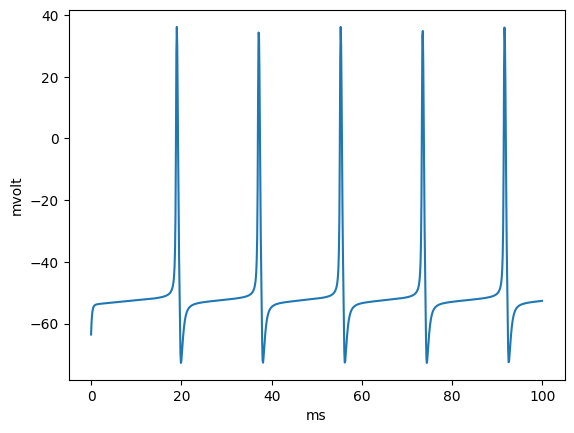

In [17]:
import matplotlib.pyplot as plt

# visualization
plt.plot(times, u.math.squeeze(vs))
plt.show()

观察运行结果，很明显，我们建立的 HH 型神经元产生了 spike ，精确地表达了它的电生理特性。

当然，除了对单房室神经元进行建模，我们的 `braincell` 框架也支持对具有一定空间结构的多房室神经元进行建模，这里不做进一步讨论。

本文中举例的模型来自：

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98